# Dano's braindecode  notebook

In this notebook, I try and use the braindecode Experiment quickstart to learn some neurodoro data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from os import walk
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from tpot import TPOTRegressor
from math import sqrt
import pyriemann
from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import read_montage
from glob import glob
from pyriemann.utils.viz import plt, plot_confusion_matrix, plot_embedding
from pyriemann.estimation import Covariances, HankelCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.clustering import Potato

In [3]:
# Data has been collected, let's import it

data = pd.read_csv("../muse-data/josh_sep_21RawEEG2.csv", header=0, index_col=False)

In [4]:
# Remove all the early epochs before the experiment started

data = data[data.Performance != 0]

In [5]:
# State is handcoded in right now to make this a classification problem. We should work an algorithm to compute this state from performance and difficulty

data['State'] = 1
data.loc[data.Difficulty > 40, 'State'] = 1
data.iloc[52000:, data.columns.get_loc('State')] = 3

# rearrange columns, remove timestamp
data = data[['Difficulty', 'Performance', 'State', 'Channel 1', 'Channel 2', 'Channel 3', 'Channel 4']]

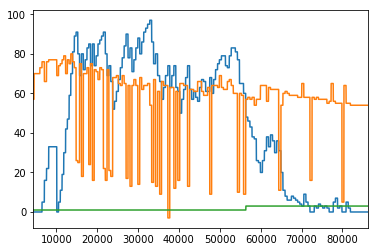

In [6]:
%matplotlib inline
data.Difficulty.plot()
data.Performance.plot()
data.State.plot()

In [10]:
data[data['State'] == 3]

,Difficulty,Performance,State,Channel 1,Channel 2,Channel 3,Channel 4
56356,48,57,3,845.151810,842.740085,852.134130,864.341535
56357,48,57,3,837.083075,847.135720,851.390069,861.691623
56358,48,57,3,838.981294,851.274613,846.872986,868.719913
56359,48,57,3,838.529094,849.786773,847.575048,857.815238
56360,48,57,3,836.040513,852.661670,848.126707,861.303466
56361,48,57,3,842.008117,849.601644,841.788890,851.643668
56362,48,57,3,845.835239,855.415074,843.826221,852.506076
56363,48,57,3,835.251807,850.776520,846.191141,866.901276
56364,48,57,3,833.613961,855.858377,846.398033,862.221843
56365,48,57,3,831.523069,851.131467,845.683126,857.027460


In [11]:
sfreq = 256

# name of each channels 
ch_names = ['Diff', 'Perf', 'State', 'TP9', 'FP1', 'FP2', 'TP10']

# type of each channels
ch_types = ['stim'] * 3 + ['eeg'] * 4
montage = read_montage('standard_1005')

# get data
data = data.T
data

# convert in Volts (from uVolts)
#data[:-1] *= 1e-6

# create mne objects
info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, montage=montage)
raw = (RawArray(data=data, info=info))

Creating RawArray with float64 data, n_channels=7, n_times=81936
    Range : 0 ... 81935 =      0.000 ...   320.059 secs
Ready.


tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
Effective window size : 8.000 (s)


<ipython-input-12-c492566b21b4>:3: DeprecationWarning: tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
  raw.plot_psd(picks=[3]);
/Users/joshharris/anaconda3/lib/python3.6/site-packages/mne/viz/raw.py:614: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


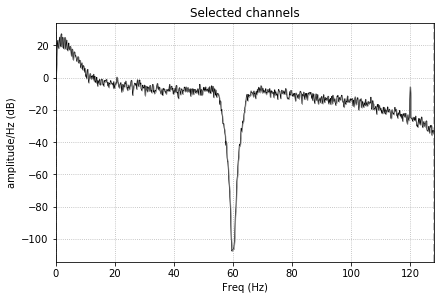

In [12]:
## Plot the PSD of the EEG data just to make sure it looks alright

raw.plot_psd(picks=[3]);


In [13]:
raw.filter(2, 50, method='iir')

Setting up band-pass filter from 2 - 50 Hz


<RawArray  |  None, n_channels x n_times : 7 x 81936 (320.1 sec), ~4.4 MB, data loaded>

## Epochs

In [17]:
from mne import make_fixed_length_events, Epochs

# Make an events array with epoch times every .5 seconds
event = make_fixed_length_events(raw, 1, duration=0.5)

# Create the model

# Make an epochs array object from the raw dataset with events array event, length of 2 seconds
epochs = Epochs(raw, event, tmin=0, tmax=4, preload=True, reject={'eeg': 200})

epochs

640 matching events found
0 projection items activated
Loading data for 640 events and 1025 original time points ...
    Rejecting  epoch based on EEG : ['FP1', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2', 'TP10']
    Rejecting  epoch based on EEG : ['FP2', 'TP10']
    Rejecting  epoch based on EEG : ['FP2', 'TP10']
    Rejecting  epoch based on EEG : ['FP1', 'FP2

<Epochs  |  n_events : 600 (all good), tmin : 0.0 (s), tmax : 4.0 (s), baseline : (None, 0), ~32.9 MB, data loaded>

In [18]:
X = epochs.copy().pick_types(eeg=True).get_data()

y = epochs.copy().pick_types(eeg=False, stim=True).get_data().mean(axis=2)
print(X.shape, y.shape)

(600, 4, 1025) (600, 3)


In [19]:
# The labels matrix has three columns, Difficulty (0) and Performance (1) and State (2)

# We'll need to use our State variable for decode (it only does classification not regression rn)
y = np.round(y[:,2])

In [20]:
y

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [22]:
# Convert to braindecode format
from braindecode.datautil.signal_target import SignalAndTarget
from braindecode.datautil.splitters import split_into_two_sets

X = (X* 1e6).astype(np.float32)
y = y.astype(np.int64)

train_set = SignalAndTarget(X, y)
test_set = SignalAndTarget(X, y)
train_set, valid_set = split_into_two_sets(train_set, first_set_fraction=0.8)

In [27]:
# Create the model

from braindecode.models.shallow_fbcsp import ShallowFBCSPNet
from torch import nn
from braindecode.torch_ext.util import set_random_seeds
from braindecode.models.util import to_dense_prediction_model
import torch as th

cuda = th.cuda.is_available()
set_random_seeds(seed=20170629, cuda=False)

# This will determine how many crops are processed in parallel
input_time_length = 450
n_classes = 4
in_chans = train_set.X.shape[1]
# final_conv_length determines the size of the receptive field of the ConvNet
model = ShallowFBCSPNet(in_chans=in_chans, n_classes=n_classes, input_time_length=input_time_length,
                        final_conv_length=12).create_network()
to_dense_prediction_model(model)

if cuda:
    model.cuda()

ImportError: dlopen(/Users/joshharris/anaconda3/lib/python3.6/site-packages/torch/_C.cpython-36m-darwin.so, 10): Symbol not found: _PySlice_AdjustIndices
  Referenced from: /Users/joshharris/anaconda3/lib/python3.6/site-packages/torch/_C.cpython-36m-darwin.so
  Expected in: flat namespace
 in /Users/joshharris/anaconda3/lib/python3.6/site-packages/torch/_C.cpython-36m-darwin.so

In [28]:
from torch import optim

optimizer = optim.Adam(model.parameters())

ImportError: dlopen(/Users/joshharris/anaconda3/lib/python3.6/site-packages/torch/_C.cpython-36m-darwin.so, 10): Symbol not found: _PySlice_AdjustIndices
  Referenced from: /Users/joshharris/anaconda3/lib/python3.6/site-packages/torch/_C.cpython-36m-darwin.so
  Expected in: flat namespace
 in /Users/joshharris/anaconda3/lib/python3.6/site-packages/torch/_C.cpython-36m-darwin.so

In [348]:
from braindecode.torch_ext.util import np_to_var
# determine output size
test_input = np_to_var(np.ones((2, in_chans, input_time_length, 1), dtype=np.float32))
if cuda:
    test_input = test_input.cuda()
out = model(test_input)
n_preds_per_input = out.cpu().data.numpy().shape[2]
print("{:d} predictions per input/trial".format(n_preds_per_input))

187 predictions per input/trial


In [349]:
from braindecode.experiments.experiment import Experiment
from braindecode.datautil.iterators import CropsFromTrialsIterator
from braindecode.experiments.monitors import RuntimeMonitor, LossMonitor, CroppedTrialMisclassMonitor, MisclassMonitor
from braindecode.experiments.stopcriteria import MaxEpochs
import torch.nn.functional as F
from braindecode.torch_ext.modules import Expression
# Iterator is used to iterate over datasets both for training
# and evaluation
iterator = CropsFromTrialsIterator(batch_size=32,input_time_length=input_time_length,
                                  n_preds_per_input=n_preds_per_input)

# Loss function takes predictions as they come out of the network and the targets
# and returns a loss
loss_function = lambda preds, targets: F.nll_loss(th.mean(preds, dim=2, keepdim=False), targets)

# Could be used to apply some constraint on the models, then should be object
# with apply method that accepts a module
model_constraint = None
# Monitors log the training progress
monitors = [LossMonitor(), MisclassMonitor(col_suffix='sample_misclass'),
            CroppedTrialMisclassMonitor(input_time_length), RuntimeMonitor(),]
# Stop criterion determines when the first stop happens
stop_criterion = MaxEpochs(20)
exp = Experiment(model, train_set, valid_set, test_set, iterator, loss_function, optimizer, model_constraint,
          monitors, stop_criterion, remember_best_column='valid_misclass',
          run_after_early_stop=True, batch_modifier=None, cuda=cuda)

In [350]:
# need to setup python logging before to be able to see anything
import logging
import sys
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                     level=logging.DEBUG, stream=sys.stdout)
exp.run()

2017-09-22 11:03:12,014 INFO : Run until first stop...
2017-09-22 11:03:23,434 INFO : Epoch 0
2017-09-22 11:03:23,437 INFO : train_loss                15.00204
2017-09-22 11:03:23,438 INFO : valid_loss                72.96835
2017-09-22 11:03:23,439 INFO : test_loss                 26.59530
2017-09-22 11:03:23,440 INFO : train_sample_misclass     0.95230
2017-09-22 11:03:23,440 INFO : valid_sample_misclass     1.00000
2017-09-22 11:03:23,442 INFO : test_sample_misclass      0.96184
2017-09-22 11:03:23,443 INFO : train_misclass            0.99167
2017-09-22 11:03:23,444 INFO : valid_misclass            1.00000
2017-09-22 11:03:23,445 INFO : test_misclass             0.99333
2017-09-22 11:03:23,445 INFO : runtime                   0.00000
2017-09-22 11:03:23,446 INFO : 
2017-09-22 11:03:23,450 INFO : New best valid_misclass: 1.000000
2017-09-22 11:03:23,456 INFO : 
2017-09-22 11:03:47,461 INFO : Time only for training updates: 23.83s
2017-09-22 11:03:58,612 INFO : Epoch 1
2017-09-22 11:0

Best Epoch:
```
2017-09-22 11:15:15,655 INFO : Epoch 6
2017-09-22 11:15:15,656 INFO : train_loss                0.55220
2017-09-22 11:15:15,661 INFO : valid_loss                0.17202
2017-09-22 11:15:15,664 INFO : test_loss                 0.55220
2017-09-22 11:15:15,665 INFO : train_sample_misclass     0.19732
2017-09-22 11:15:15,675 INFO : valid_sample_misclass     0.05496
2017-09-22 11:15:15,683 INFO : test_sample_misclass      0.19732
2017-09-22 11:15:15,686 INFO : train_misclass            0.13667
2017-09-22 11:15:15,692 INFO : valid_misclass            0.00833
2017-09-22 11:15:15,695 INFO : test_misclass             0.13667
2017-09-22 11:15:15,698 INFO : runtime                   11.22553

```